<a href="https://colab.research.google.com/github/logansmith9454/cse450/blob/main/notebooks/starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [232]:
# !pip install scikit-learn==1.5.2
# !pip install --upgrade xgboost scikit-learn

In [233]:
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from IPython.display import display, HTML
from branca.colormap import LinearColormap
from google.colab import files
from sklearn.model_selection import GridSearchCV

In [234]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  object 
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_l

In [235]:
def format_data(dataset):
  dataset['is_renovated'] = (dataset['yr_renovated'] != 0).astype(int)
  ren_med = dataset[dataset['yr_renovated'] != 0]['yr_renovated'].median()
  dataset['yr_renovated'] = dataset['yr_renovated'].replace(0, ren_med)

  dataset['has_basement'] = (dataset['sqft_basement'] != 0).astype(int)
  base_med = dataset[dataset['sqft_basement'] != 0]['sqft_basement'].median()
  dataset['sqft_basement'] = dataset['sqft_basement'].replace(0, base_med)

  grade_bins = [0, 3, 7, 11, 13]
  grade_labels = ['low', 'medium', 'high', 'very high']
  dataset['grade_category'] = pd.cut(dataset['grade'], bins=grade_bins, labels=grade_labels)


  continuous_features = ['id', 'date', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
  discrete_features = ['floors', 'waterfront', 'view', 'condition', 'grade_category', 'zipcode', 'bathrooms', 'has_basement', 'is_renovated']

  # columns_to_drop = ['lat', 'long', 'id', 'date']
  columns_to_drop = ['id', 'date']
  for column in columns_to_drop:
    if column in continuous_features:
      continuous_features.remove(column)
    if column in discrete_features:
      discrete_features.remove(column)
  if 'price' in dataset.columns:
    y = dataset['price']
    columns_to_drop.append('price')
    X = dataset.drop(columns_to_drop, axis=1)
    X = pd.get_dummies(X, columns=discrete_features, drop_first=True)
  else:
    y = None
    X = dataset.drop(columns_to_drop, axis=1)
    X = pd.get_dummies(X, columns=discrete_features, drop_first=True)

  new_features_to_drop = ["bathrooms_5.5",
                          "bathrooms_5.7",
                          "bathrooms_7.5",
                          "bathrooms_6.5",
                          "bathrooms_6.75",
                          "bathrooms_0.5",
                          "zipcode_98198",
                          "bathrooms_1.2",
                          "bathrooms_0.7",
                          "bathrooms_5.7",
                          "zipcode_98155",
                          "zipcode_98148",
                          "bathrooms_1.25",
                          "bathrooms_0.75",
                          "bathrooms_5.75",
                          "zipcode_98042",
                          "zipcode_98058",
                          "zipcode_98056",
                          "bathrooms_1.75",
                          "bathrooms_5.25",
                          "floors_3.5",
                          "grade_category_very high",
                          "zipcode_98030",
                          "zipcode_98022",
                          "zipcode_98007",
                          "zipcode_98002",
                          "zipcode_98116",
                          "zipcode_98117",
                          "zipcode_98055",
                          "zipcode_98077",
                          "zipcode_98028",
                          "zipcode_98188",
                          "zipcode_98038",
                          "zipcode_98070",
                          "zipcode_98031",
                          "zipcode_98032",
                          "zipcode_98019",
                          "bathrooms_4.25",
                          "bathrooms_2.0",
                          "zipcode_98003"

                          ]
  for feature in new_features_to_drop:
    if feature in X.columns:
      X.drop(feature, axis=1, inplace=True)
  for feature in new_features_to_drop:
    if feature in discrete_features:
      discrete_features.remove(feature)
    if feature in continuous_features:
      continuous_features.remove(feature)
  return X, y, continuous_features, discrete_features


def create_model(X, y, continuous_features, discrete_features):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  scaler = MinMaxScaler()
  X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
  X_test[continuous_features] = scaler.transform(X_test[continuous_features])
  model = XGBRegressor(n_estimators=150, learning_rate=0.6, max_depth=3)

  return model, continuous_features, discrete_features, X_train, X_test, y_train, y_test

In [236]:
X, y, continuous_features, discrete_features = format_data(housing)
model, continuous_features, discrete_features, X_train, X_test, y_train, y_test = create_model(X, y, continuous_features, discrete_features)
# sns.pairplot(X_train.join(y_train), y_vars=['price'], x_vars=continuous_features)

In [237]:
# Create a pairplot to visualize the relationships of discrete features in the training set after one-hot encoding
# g = sns.PairGrid(housing, y_vars=['price'], x_vars=discrete_features)
# g.map(sns.boxplot)

In [238]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: ${mse**0.5:,.2f}")

Mean Squared Error: 18325814425.37332
Root Mean Squared Error: $135,372.87


In [239]:
# center_lat = housing['lat'].mean()
# center_lon = housing['long'].mean()

# m = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

# # Create a color map based on price
# min_price = housing['price'].min()
# max_price = housing['price'].max()
# colormap = LinearColormap(['green', 'yellow', 'red'], vmin=min_price, vmax=max_price)

# # Add markers for each house, color-coded by price
# for idx, row in housing.iterrows():
#     folium.CircleMarker(
#         location=[row['lat'], row['long']],
#         radius=5,
#         color=colormap(row['price']),
#         fill=True,
#         fill_color=colormap(row['price']),
#         fill_opacity=0.7
#     ).add_to(m)

# # Add the colormap to the map
# colormap.add_to(m)

# display(m)

In [240]:
mini_holdout = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")

X_holdout = format_data(mini_holdout)[0]

# Reindex X_holdout to match the columns of X_train
X_holdout = X_holdout.reindex(columns=X_train.columns, fill_value=0)


# Make predictions using the already trained model
predictions = model.predict(X_holdout)

predictions = np.array(predictions).astype(int)
print(predictions)
print(f"predictions: {len(predictions)}")
print(f"holdout: {len(mini_holdout)}")
output_df = pd.DataFrame(predictions, columns=['predictions'])

file_number = 1
file_name = f'{file_number}-mini-predictions.csv'
# output_df.to_csv(file_name, index=False)
# files.download(file_name)

[ 919691 1228874  876685  819894 1011744  927060 1490721 1006000  864655
 1035394  927119  946889 1064029  946889  849487  925785 2241389  727093
  872749 1034452  748858 1609834 1001170 1028024 1051604  903985 2089808
  993751 1378502 1264521 3275754  909932  823326  723353  946889 1548096
  896269 1057727  921324  946152 1056355  845216  819952 1901341  726530
 1066873  742003 1008196 1609834 1027755  894110 1609834 1040004  849487
 1074409  920030  919691  946889 1023203 1609834 1031872  876685 1066858
  874711 2189030 1023203  876685  976782 1018373  902393  843276 1018265
 1081954 1609834 2125813 1946305  646476 1276243  839890 1028024 1043321]
predictions: 81
holdout: 81


Feature Importances:
condition_4       0.001155
zipcode_98008     0.001091
bathrooms_5.0     0.001088
bathrooms_4.75    0.001029
zipcode_98168     0.001001
bathrooms_1.5     0.000857
bathrooms_4.0     0.000817
zipcode_98023     0.000758
zipcode_98136     0.000680
has_basement_1    0.000179
dtype: float32


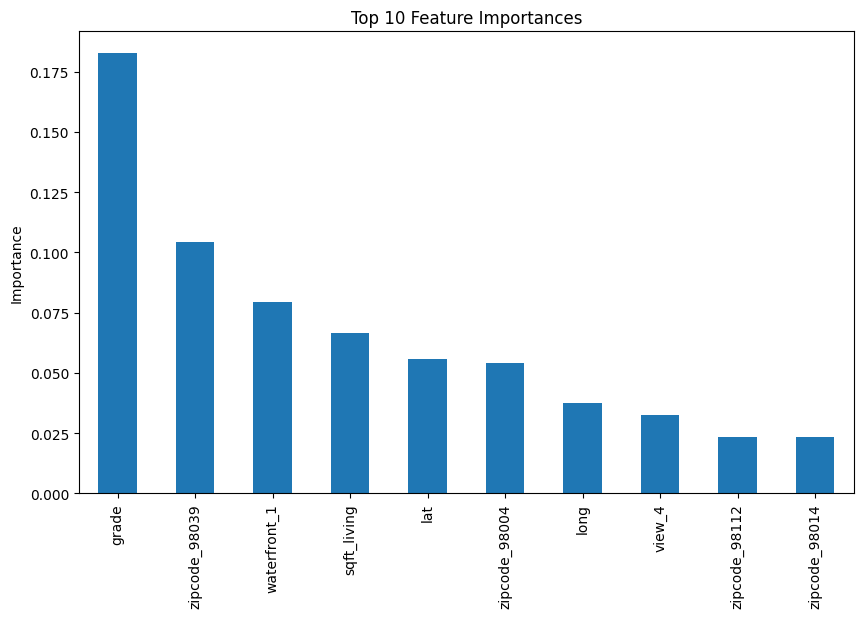

In [241]:
# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Create a pandas Series for easier visualization
feature_importances_series = pd.Series(feature_importances, index=X_train.columns)

# Sort the features by importance
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Print the sorted feature importances
print("Feature Importances:")
print(sorted_feature_importances.tail(10))

# Optionally, visualize the top N features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sorted_feature_importances[:10].plot(kind='bar')
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance")
plt.show()